## Libnames

In [84]:
import os
import sys

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))

get_script_path()

'C:\\Users\\rhais\\Anaconda2\\lib\\site-packages'

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, ElasticNet
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Funções  - data prep

In [2]:
def standard_scaler_manual (data) :
    data2 = (data - data.mean())/data.std()
    return data2


def fit_transform_with_function (data, function, sklearn):
    scaler = function
    
    if sklearn == 'True':
        scaler = function
        data_transformed = scaler.fit_transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
        
    else:
        data_transformed2 = data.apply(function)
        
    return scaler, data_transformed2

#X_train.apply(standard_scaler_manual)


def transform_with_function (data, scaler, sklearn):
    
    if sklearn == 'True':
        data_transformed = scaler.transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
    
    else:
        data_transformed2 = data.apply(scaler)
    
        
    
    return data_transformed2



## Funções Modelagem

In [3]:
def split_train_test_data (data, name_target, test_size, random_state):
    
    X_all = data.drop([name_target], axis = 1)
    y_all = data[name_target]

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = test_size ,random_state = random_state)

    print ("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
    print ("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
    
    X_train.reset_index(drop=True, inplace = True)
    X_test.reset_index(drop=True, inplace = True)
    y_train.reset_index(drop=True, inplace = True)
    y_test.reset_index(drop=True, inplace = True)
    
    return X_train, X_test, y_train, y_test

def add_missing_dummy_columns (new_data, train_columns):
    missing_cols = set(train_columns) - set(new_data_columns)
    for c in missing_cols:
        new_data[c] = 0

def fix_columns (new_data, train_columns):
    add_missing_dummy_columns(new_data, train_columns)
    assert(set(train_columns) - set(new_data.columns) == set())
    extra_cols = set(new_data.columns) - set(train_columns)
    if extra_cols:
        print('columns extra', extra_cols)
    new_data = new_data[train_columns]
    return new_data

def grid_search_model (x, y, clf, parameters, scorer, cv, verbose):
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv =  cv, verbose= verbose)
    start = time()
    grid_fit = grid_obj.fit(x, y)
    end = time()
    print ("Best score:" , grid_fit.best_score_)
    print ("Best parameters:" , grid_fit.best_params_)
    #print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    return grid_fit, grid_fit.best_estimator_


def model_reg_holdout (reg, X_train, y_train, X_test, y_test, metrics):
    
    reg.fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)

    #coeficientes
    #print "Number of coefficients:", len(reg.coef_)
    #print "Estimated intercept coefficient:", reg.intercept_
   
    #print '\n'
    
    #coefficients = pd.DataFrame(zip(X_train.columns, reg.coef_), columns = ['features', 'coefficients'])
    #coefficients.sort_values(by = 'coefficients', ascending = False, inplace=True)
    #print coefficients
    
        
    first_metric = True
    for metric in metrics:
            name_metric = metric.__name__
            m_tr = metric(y_train, pred_train)
            m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                '1.Treino': [m_tr],
                '2.Teste' : [m_te]
            }
            resultados_aux = pd.DataFrame(m_tr_te, index = [str(name_metric)])
            #print(resultados_aux)
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 0)    
        
    return results_folds

def model_reg_cv (model, X, y, cv, metrics):

    first = True

    for train_index, test_index in cv.split(X):
        #print(train_index)
        model2 = model.fit(X.iloc[train_index],y[train_index])
        
        pred_train = model2.predict(X.iloc[train_index])
        pred_test = model2.predict(X.iloc[test_index])

        y_train = y[train_index]
        y_test = y[test_index]
        
        first_metric = True
        for metric in metrics:
            name_metric = metric.__name__
            m_tr = metric(y_train, pred_train)
            m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                str(name_metric) +'- 1.Treino': [m_tr],
                str(name_metric) +'- 2.Teste' : [m_te]
            }
            resultados_aux = pd.DataFrame(m_tr_te)
            
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 1)    
                
        #results_folds2 = results_folds
        
            #resultados.index = ['MSE','MAE', 'R2']
        if first == True:
            results = results_folds
            first = False
        else:
            results = pd.concat([results, results_folds], axis = 0)    

    results.index = range(cv.get_n_splits(X))
    results_mean = np.transpose(pd.DataFrame(results.mean(), columns=['mean']))
    results = pd.concat([results, results_mean], axis = 0)

    return results

    
    #print(results_folds)
        

def plot_graphs ( X_train, y_train, X_test, y_test):
    plt.scatter(y_train, lm.predict(X_train))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Train Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()

    plt.scatter(y_test, lm.predict(X_test))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Test Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()
    
def plot_residuals(X_train, y_train, X_test, y_test):
    plt.scatter(lm.predict(X_train), lm.predict(X_train)-y_train, c='b', s=40, alpha = 0.5)
    plt.scatter(lm.predict(X_test), lm.predict(X_test)-y_test, c='g', s=40, alpha = 0.5)
    #plt.hlines(y=0, xmin = 0, xmax = 50)
    plt.title('Residual Plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()

def coeficientes_reglinear (data, model):
    df = {
        '1.features' : data.columns,
        '2.coeficientes' : model.coef_
    }
    df = pd.DataFrame(df)
    df.sort_values(by = '2.coeficientes', ascending=False, inplace=True)
    return df

### Dados

In [4]:
data = pd.read_csv('dados_Q2.csv')
data.head()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,target
0,-0.79695,-0.83606,-0.23906,-0.56451,-0.96625,-0.99640,-2.66871,-0.27731,0.49983,1.06721,10.421121
1,-0.57497,2.10162,0.64700,1.00683,-0.80753,-0.28788,0.40271,-0.10339,-1.81998,0.07313,-134.640756
2,0.87712,-1.62489,0.02172,-1.83379,-0.34769,0.07845,0.59389,-0.31391,0.18052,1.27497,-14.972669
3,-1.45677,0.14963,-1.22462,1.19530,-1.87158,-0.59362,-0.52649,-0.91518,-1.01272,-1.34567,-150.997202
4,-0.14835,0.99951,1.05594,-0.35405,1.01620,-0.61699,0.30384,-0.37157,0.69998,0.76953,15.864833


In [28]:
boston = load_boston()

In [29]:
print boston.keys()
print boston.data.shape
print boston.feature_names
#boston.DESCR

['data', 'feature_names', 'DESCR', 'target']
(506L, 13L)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [30]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [31]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [32]:
data['PRICE'] = boston.target

In [33]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [34]:
X_train, X_test, y_train, y_test = split_train_test_data(data, 'PRICE', test_size = 0.20 ,random_state = 791231)

Training set has 404 samples and 13 features.
Testing set has 102 samples and 13 features.


### base da Lara

In [63]:
path='C:\\Users\\rhais\\Desktop\\python-codes\\applied algorithms\\regression examples\\'
data = pd.read_csv(path + 'data_regress.csv', sep=';')
data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,5.721446,-0.560476,-0.995799,-0.511604,-0.150307,0.196550,1,0,0,0
2,6.537608,-0.230177,-1.039955,0.236938,-0.327757,0.650113,1,0,0,0
3,3.289661,1.558708,-0.017980,-0.541589,-1.448165,0.671004,0,0,1,0
4,15.069029,0.070508,-0.132175,1.219228,-0.697285,-1.284158,1,1,1,0
5,5.882468,0.129288,-2.549343,0.174136,2.598490,-2.026110,1,0,0,1


In [64]:
X = data.drop(['y'], axis = 1)
y = data['y']
X_train = X.iloc[0:750]
X_train.reset_index(drop=True, inplace=True)
y_train = y[0:750]
y_train.reset_index(drop=True, inplace=True)

In [65]:
data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,5.721446,-0.560476,-0.995799,-0.511604,-0.150307,0.196550,1,0,0,0
2,6.537608,-0.230177,-1.039955,0.236938,-0.327757,0.650113,1,0,0,0
3,3.289661,1.558708,-0.017980,-0.541589,-1.448165,0.671004,0,0,1,0
4,15.069029,0.070508,-0.132175,1.219228,-0.697285,-1.284158,1,1,1,0
5,5.882468,0.129288,-2.549343,0.174136,2.598490,-2.026110,1,0,0,1


### data prep - normalização dos dados - usando a biblioteca e usando uma função específica

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler()


In [12]:
scaler, X_train_final = fit_transform_with_function(X_train,  StandardScaler(), 'True')
X_train_final.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.399699,-0.484437,-0.172623,-0.288288,-0.085823,-0.517664,0.861626,-0.667972,-0.389419,0.152949,-0.302769,0.405984,0.489518
1,-0.397756,-0.484437,-0.382086,-0.288288,-0.318306,-0.166590,0.757293,-0.635883,-0.505355,-0.133371,1.129208,0.379747,-0.047046
2,-0.406474,-0.484437,-1.033588,-0.288288,-0.404410,0.791261,0.196056,-0.401240,-0.505355,-0.658292,-0.857082,0.363262,-0.795192
3,0.139224,-0.484437,0.996036,-0.288288,0.491078,0.957122,-0.048586,-0.582764,1.697429,1.548762,0.805859,0.170666,-0.139700
4,-0.390968,0.467094,-0.772121,-0.288288,-1.084637,-0.085042,0.368744,2.038800,-0.273483,-0.455482,0.297738,0.187616,-0.348517


In [13]:
X_test_final = transform_with_function(X_test, scaler, 'True')
X_test_final.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.122900,-0.484437,1.209833,-0.288288,2.703967,-1.403642,0.901200,-0.960861,-0.505355,-0.020036,-1.734746,-3.150135,0.479837
1,-0.411133,-0.484437,-0.597327,-0.288288,-0.757440,0.184483,0.357951,0.572744,-0.853162,-0.980403,-0.302769,0.428622,-0.488189
2,0.562595,-0.484437,0.996036,-0.288288,1.343514,-0.485874,0.408319,-0.465846,1.697429,1.548762,0.805859,-4.138424,0.590469
3,-0.403214,0.056205,-0.481761,-0.288288,-0.283864,-0.550837,-1.077522,0.802403,-0.505355,-0.568817,-1.503782,0.354323,0.420373
4,1.293269,-0.484437,0.996036,-0.288288,1.231578,-1.945457,1.117061,-1.030594,1.697429,1.548762,0.805859,0.150234,2.482270


# Modelagem

Objetivos:
Criar funções de:

#### 1. Validação cruzada com grid search (aplicável pra Lasso, Ridge ou outras funcoes que variam ou não parâmetros)
    
##### Nome função: grid_search_model (x, y, clf, parameters, scorer, cv)

X -> base_explicativas

y -> base_resposta

clf -> modelo sklearn

parameters -> parâmetros pra variar tune

scorer -> métrica utilizada para avaliar melhores parâmetros

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)
 
A função exporta: melhor modelo
Print: melhor score, melhor parâmetro, tempo.


####  2. Validação cruzada sem grid search (aplicável pra qualquer modelo) - exporta métricas (mae, mse,r2) para cada fold e respectivas médias (dentro das partições)

##### Nome função: model_reg_cv (model, X, y, cv):

X -> base_explicativas

y -> base_resposta

model -> modelo sklearn

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)

A função exporta: treino e teste das partições do cv com mae, mse, r2
Print - coeficientes

#### 3. HoldOut - resultados e fit do modelo em uma base treino específica e aplicação na base teste com  métricas

##### Nome função: model_reg_holdout (reg, X_train, y_train, X_test, y_test)

X_train -> base_explicativas - treino

y_train -> base_resposta - treino

X_test -> base_explicativas - teste

y_test -> base_resposta - teste

reg -> modelo sklearn

A função exporta: treino e teste  com mae, mse, r2


## Regressão Linear

###  CV

In [5]:
data.head()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,target
0,-0.79695,-0.83606,-0.23906,-0.56451,-0.96625,-0.99640,-2.66871,-0.27731,0.49983,1.06721,10.421121
1,-0.57497,2.10162,0.64700,1.00683,-0.80753,-0.28788,0.40271,-0.10339,-1.81998,0.07313,-134.640756
2,0.87712,-1.62489,0.02172,-1.83379,-0.34769,0.07845,0.59389,-0.31391,0.18052,1.27497,-14.972669
3,-1.45677,0.14963,-1.22462,1.19530,-1.87158,-0.59362,-0.52649,-0.91518,-1.01272,-1.34567,-150.997202
4,-0.14835,0.99951,1.05594,-0.35405,1.01620,-0.61699,0.30384,-0.37157,0.69998,0.76953,15.864833


In [28]:
X = data.iloc[:,:-1].values
X

array([[-0.79695, -0.83606, -0.23906, ..., -0.27731,  0.49983,  1.06721],
       [-0.57497,  2.10162,  0.647  , ..., -0.10339, -1.81998,  0.07313],
       [ 0.87712, -1.62489,  0.02172, ..., -0.31391,  0.18052,  1.27497],
       ...,
       [-1.65414,  0.86143,  0.74265, ..., -1.34945, -0.84697,  0.61386],
       [-1.02855,  2.65716, -1.27631, ..., -0.44761, -0.34866, -0.56921],
       [ 0.41938,  0.30408, -0.8964 , ...,  0.33686, -0.76007,  0.87146]])

In [29]:
X.shape

(200, 10)

In [30]:
y = data['target'].values

In [33]:
X2=data.iloc[:,:-1]
y2=data['target']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2,
                                                    test_size = .3, 
                                                    random_state = 42,
                                                    shuffle = False, 
                                                    stratify = None)
lm = LinearRegression(fit_intercept = True, 
                           normalize = False, 
                           copy_X=True, n_jobs=None)

'''X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)'''

'X_train.reset_index(drop=True, inplace=True)\nX_test.reset_index(drop=True, inplace=True)\ny_train.reset_index(drop=True, inplace=True)\ny_test.reset_index(drop=True, inplace=True)'

In [60]:
metrics = [mean_squared_error, r2_score, mean_absolute_error]
table = model_reg_cv(lm, X2, y2, LeaveOneOut(), metrics)
table['rmse_treino'] = table['mean_squared_error- 1.Treino']**(0.5)
table['rmse_teste'] = table['mean_squared_error- 2.Teste']**(0.5)
rmse_treino_medio = table.rmse_treino[0:table.shape[0]-1].mean()
rmse_teste_medio = table.rmse_teste[0:table.shape[0]-1].mean()
print( 'Rmse medio treino e teste, respectivamente: ', rmse_treino_medio, 'e,', rmse_teste_medio )
table.tail()

Rmse medio treino e teste, respectivamente:  0.06609267255415677 e, 0.05644769506886732


,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste,rmse_treino,rmse_teste
196,0.004390,0.000237,1.0,0.0,0.053412,0.015407,0.066261,0.015407
197,0.004391,0.000023,1.0,0.0,0.053475,0.004789,0.066268,0.004789
198,0.004390,0.000310,1.0,0.0,0.053410,0.017608,0.066258,0.017608
199,0.004389,0.000588,1.0,0.0,0.053387,0.024254,0.066248,0.024254
mean,0.004368,0.004922,1.0,0.0,0.053220,0.056448,0.066093,0.070158


In [24]:
### LEAVE-ONE-OUT cross-validation
loo = LeaveOneOut()
RMSE_loo_te = []
RMSE_loo_tr = []

In [36]:
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] TEST: [0]
[[-0.57497  2.10162  0.647   ... -0.10339 -1.81998  0.07313]
 [ 0.87712 -1.62489  0.02172 ... -0.31391  0.18052  1.27497]
 [-1.45677  0.14963 -1.22462 ... -0.91518 -1.01272 -

 -1.78368846e+02 -6.34907688e+01 -2.20091897e+01] [-27.82000741]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] TEST: [68]
[[-0.79695 -0.83606 -0.23906 ... -0.27731  0.49983  1.06721]
 [-0.57497  2.10162  0.647   ... -0.10339 -1.81

 -1.78368846e+02 -6.34907688e+01 -2.20091897e+01] [-19.11688396]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] TEST: [119]
[[-0.79695 -0.83606 -0.23906 ... -0.27731  0.49983  1.06721]
 [-0.57497  2.10162  0.647   ... -0.10339 -1.8

[[-0.79695 -0.83606 -0.23906 ... -0.27731  0.49983  1.06721]
 [-0.57497  2.10162  0.647   ... -0.10339 -1.81998  0.07313]
 [ 0.87712 -1.62489  0.02172 ... -0.31391  0.18052  1.27497]
 ...
 [-1.65414  0.86143  0.74265 ... -1.34945 -0.84697  0.61386]
 [-1.02855  2.65716 -1.27631 ... -0.44761 -0.34866 -0.56921]
 [ 0.41938  0.30408 -0.8964  ...  0.33686 -0.76007  0.87146]] [[-0.93707  0.39456  0.96777  0.79965  0.89104 -1.68525  0.55301  1.5802
  -0.56442  1.27037]] [ 1.04211214e+01 -1.34640756e+02 -1.49726688e+01 -1.50997202e+02
  1.58648334e+01 -7.98041211e+01  2.26096910e+01 -9.45664468e+01
  1.78599499e+01 -1.03372921e+02 -6.67443266e+01  8.02825136e+01
  6.00960763e+01 -4.72344206e+01 -1.17280414e+02 -6.26801302e+01
 -1.27073606e+02 -1.91896362e+01 -3.41109522e+01 -2.82246164e+01
  4.51622153e+00  2.03054342e+01  1.33705312e+02  6.13781895e+01
 -4.50912767e+01  1.15853952e+02 -1.75092512e+02 -5.89773508e+01
 -3.09826905e+01 -6.42038830e+01  5.17510213e+01 -1.49032468e+01
  2.68422403e

In [39]:
def MetricsRegression(y, y_pred):
    RMSE = np.sqrt(mean_squared_error(y, y_pred))
    MAE = mean_absolute_error(y, y_pred)
    return MAE, RMSE

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .3, 
                                                    random_state = 42,
                                                    shuffle = False, 
                                                    stratify = None)
lm = LinearRegression(fit_intercept = True, 
                           normalize = False, 
                           copy_X=True, n_jobs=None)

'''X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)'''

'X_train.reset_index(drop=True, inplace=True)\nX_test.reset_index(drop=True, inplace=True)\ny_train.reset_index(drop=True, inplace=True)\ny_test.reset_index(drop=True, inplace=True)'

In [48]:
for train, test in loo.split(X_train):
    lm.fit(X[train], y[train])
    _, RMSE = MetricsRegression(y[train], lm.predict(X[train]))
    RMSE_loo_tr.append(RMSE)
    
    y_hat = lm.predict(X[test])
    _, RMSE = MetricsRegression(y[test], y_hat)
    RMSE_loo_te.append(RMSE)

In [56]:
min(table.rmse_teste)

0.0018841957026154432

In [55]:
min(RMSE_loo_te)

0.0002475789481763968

In [ ]:
RMSE_loo_te

In [88]:
metrics = [mean_squared_error, r2_score, mean_absolute_error]
lm = LinearRegression()
table = model_reg_cv(lm, X_train, y_train, KFold(3), metrics)
table['rmse_treino'] = table['mean_squared_error- 1.Treino']**(0.5)
table['rmse_teste'] = table['mean_squared_error- 2.Teste']**(0.5)
rmse_treino_medio = table.rmse_treino[0:table.shape[0]-1].mean()
rmse_teste_medio = table.rmse_teste[0:table.shape[0]-1].mean()
print 'Rmse medio treino e teste, respectivamente: ', rmse_treino_medio, 'e,', rmse_teste_medio 
table

Rmse medio treino e teste, respectivamente:  3.85713127961 e, 4.01613954986


,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste,rmse_treino,rmse_teste
0,15.446316,15.148468,0.717767,0.671520,2.907874,2.999426,3.930180,3.892103
1,15.457840,14.815035,0.685733,0.740821,2.871304,2.987274,3.931646,3.849030
2,13.760893,18.552704,0.734168,0.644666,2.918094,3.013945,3.709568,4.307285
mean,14.888350,16.172069,0.712556,0.685669,2.899091,3.000215,3.858542,4.021451


In [14]:
cv_kfold = KFold(6, random_state=12)
cv_loo = LeaveOneOut()
metrics = [mean_squared_error, r2_score, mean_absolute_error]

In [35]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# validação cruzada na regressão linear - MSE
model_reg_cv(lm, X_train_final, y_train, cv_kfold, metrics)

,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste
0,21.618668,26.595164,0.756795,0.632587,3.275871,3.664632
1,21.988410,25.003380,0.754127,0.632961,3.325174,3.303828
2,23.571535,16.916424,0.736634,0.755275,3.468801,2.906042
3,22.683992,21.619024,0.703314,0.839465,3.290454,3.558357
4,22.367153,22.727495,0.742734,0.717621,3.341313,3.511046
5,20.141830,34.889752,0.764194,0.610848,3.115179,3.950879
mean,22.061931,24.625207,0.742966,0.698126,3.302799,3.482464


### HoldOut

In [35]:
model_reg_holdout(lm, X_train, y_train, X_test, y_test, metrics)

,1.Treino,2.Teste
mean_squared_error,22.271886,20.695189
r2_score,0.741391,0.732702
mean_absolute_error,3.310888,3.291765


In [157]:
coeficientes_reglinear(X_train, lm)

,1.features,2.coeficientes
5,RM,3.716071
3,CHAS,2.550217
8,RAD,0.312450
1,ZN,0.046577
2,INDUS,0.015698
11,B,0.008684
6,AGE,0.004278
9,TAX,-0.011364
0,CRIM,-0.122871
12,LSTAT,-0.524797


### Gráficos

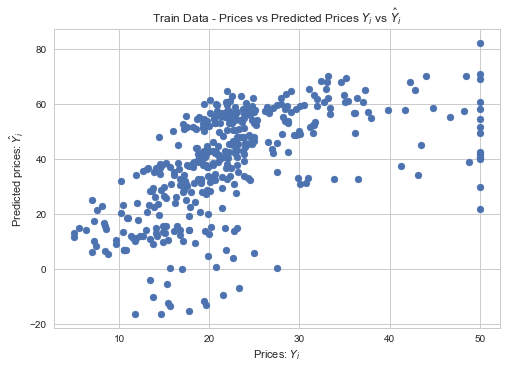

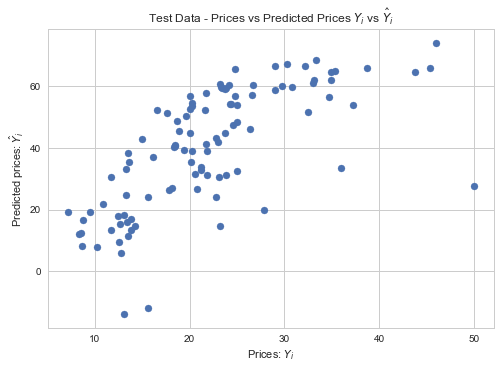

In [38]:
plot_graphs( X_train_final, y_train, X_test_final, y_test)    

### Plot residuals

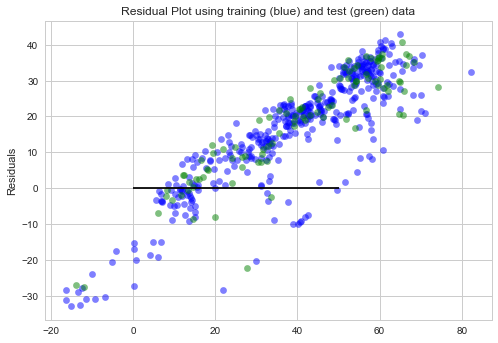

In [36]:
plot_residuals(X_train_final, y_train, X_test_final, y_test)

## Lasso 

### GridSearch + CV

In [44]:
lasso = Lasso()
parameters_lasso = {
    'alpha' : [0.001, 0.005, 0.008, 0.015,0.025]
}
grid, model_lasso = grid_search_model(X_train_final, y_train, lasso, parameters_lasso, 'neg_mean_squared_error', cv_kfold, 0 )
model_lasso

Best score: -24.5770794469
Best parameters: {'alpha': 0.025}
Find best parameterers in 0.3200 seconds.


Lasso(alpha=0.025, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [158]:
coeficientes_reglinear(X_train_final, model_lasso)

,1.features,2.coeficientes
5,RM,2.738120
8,RAD,2.319108
1,ZN,0.980967
11,B,0.721082
3,CHAS,0.676829
6,AGE,0.007345
2,INDUS,-0.000000
0,CRIM,-0.958437
9,TAX,-1.586801
4,NOX,-1.961428


In [49]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split3_test_score,split3_train_score,split4_test_score,split4_train_score,split5_test_score,split5_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.006667,0.001000,-24.627621,-22.061988,0.001,{u'alpha': 0.001},5,-26.593237,-21.618713,-25.005125,...,-21.612811,-22.684045,-22.723136,-22.367214,-34.892754,-20.141891,0.000943,1.192093e-07,5.491115,1.052594
1,0.005667,0.001333,-24.615644,-22.063344,0.005,{u'alpha': 0.005},4,-26.585792,-21.619799,-25.013996,...,-21.589662,-22.685312,-22.707540,-22.368676,-34.907609,-20.143363,0.001374,4.713704e-04,5.510001,1.052628
2,0.001833,0.000500,-24.607036,-22.065424,0.008,{u'alpha': 0.008},3,-26.580707,-21.621569,-25.022756,...,-21.573981,-22.687371,-22.697169,-22.371045,-34.921453,-20.145767,0.000687,5.000432e-04,5.526266,1.052495
3,0.003833,0.001833,-24.590256,-22.073857,0.015,{u'alpha': 0.015},2,-26.571032,-21.628912,-25.049155,...,-21.540164,-22.695141,-22.677380,-22.380752,-34.955968,-20.155626,0.002339,2.544033e-03,5.564137,1.051890
4,0.003500,0.000167,-24.577079,-22.094453,0.025,{u'alpha': 0.025},1,-26.561931,-21.647263,-25.102292,...,-21.499244,-22.713015,-22.668132,-22.404358,-35.016279,-20.180064,0.002754,3.726510e-04,5.618854,1.050194


In [45]:
results_folds = model_reg_cv(model_lasso,X_train_final, y_train, cv_kfold, metrics)
results_folds

,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste
0,21.647263,26.561931,0.756473,0.633046,3.254799,3.643359
1,22.021381,25.102292,0.753758,0.631509,3.303657,3.259391
2,23.600634,16.577136,0.736308,0.760184,3.451476,2.877924
3,22.713015,21.499244,0.702934,0.840355,3.264549,3.542250
4,22.404358,22.668132,0.742306,0.718358,3.323755,3.481468
5,20.180064,35.016279,0.763746,0.609437,3.103857,3.907622
mean,22.094453,24.570836,0.742588,0.698815,3.283682,3.452002


In [50]:
model_reg_holdout(model_lasso,X_train_final, y_train, X_test_final, y_test, metrics)

,1.Treino,2.Teste
mean_squared_error,22.304874,20.648776
r2_score,0.741007,0.733301
mean_absolute_error,3.291746,3.283844


auxiliar -> grid search retorna valores da base de treino caso necessário

In [124]:
'''
parameters_lasso = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
grid_obj = GridSearchCV(lasso, parameters_lasso, scoring = 'neg_mean_squared_error', cv=cv_kfold, return_train_score=True , verbose = 3)
grid_fit = grid_obj.fit(X_train_final, y_train)
cv_results = grid_fit.cv_results_
cv_results = pd.DataFrame(cv_results)

#cv_results2 = cv_results[[ u'param_alpha', u'split0_test_score', u'split0_train_score', u'split1_test_score',
#       u'split1_train_score', u'split2_test_score', u'split2_train_score',
#       u'split3_test_score', u'split3_train_score', u'split4_test_score',
#       u'split4_train_score', u'mean_test_score', u'mean_train_score' ]]
cv_results

Fitting 6 folds for each of 7 candidates, totalling 42 fits
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-26.593237, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-25.005125, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-16.903692, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-21.612811, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-22.723136, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-34.892754, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-72.451156, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-70.109634, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-69.124870, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ..................... alpha=100, score=-134.741722, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-82.297017, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-89.668707, total=   0.0s
[CV] alpha=1000 ......................................................
[CV] ..................... alpha=1000, score=-72.451156, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.2s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split3_test_score,split3_train_score,split4_test_score,split4_train_score,split5_test_score,split5_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001500,0.000667,-24.627621,-22.061988,0.001,{u'alpha': 0.001},2,-26.593237,-21.618713,-25.005125,...,-21.612811,-22.684045,-22.723136,-22.367214,-34.892754,-20.141891,7.637073e-04,0.000471,5.491115,1.052594
1,0.003833,0.000500,-24.601782,-22.067339,0.01,{u'alpha': 0.01},1,-26.577657,-21.623208,-25.029317,...,-21.564350,-22.689272,-22.690826,-22.373229,-34.930901,-20.147977,2.608788e-03,0.000500,5.537053,1.052376
2,0.003167,0.000833,-24.945068,-22.512182,0.1,{u'alpha': 0.1},3,-26.753513,-22.057508,-26.118863,...,-21.612191,-23.130311,-23.145877,-22.797407,-36.125173,-20.619885,2.266832e-03,0.000687,6.127650,1.036185
3,0.001000,0.000000,-30.503457,-28.925076,1,{u'alpha': 1},4,-29.522174,-28.416694,-31.857470,...,-32.312944,-30.161958,-29.306925,-29.248229,-42.691569,-25.964227,1.123916e-07,0.000000,7.395459,1.694777
4,0.001333,0.000333,-86.324007,-86.106333,10,{u'alpha': 10},5,-72.451156,-88.890612,-70.109634,...,-134.741722,-76.457801,-82.297017,-86.941814,-89.668707,-85.416925,4.713704e-04,0.000471,22.782135,4.556848
5,0.001833,0.000500,-86.324007,-86.106333,100,{u'alpha': 100},5,-72.451156,-88.890612,-70.109634,...,-134.741722,-76.457801,-82.297017,-86.941814,-89.668707,-85.416925,6.872308e-04,0.000500,22.782135,4.556848
6,0.001333,0.000333,-86.324007,-86.106333,1000,{u'alpha': 1000},5,-72.451156,-88.890612,-70.109634,...,-134.741722,-76.457801,-82.297017,-86.941814,-89.668707,-85.416925,4.713142e-04,0.000471,22.782135,4.556848


## KNN

In [125]:
from sklearn.neighbors import KNeighborsRegressor

In [126]:
knn = KNeighborsRegressor()
#cv = KFold(5, random_state=1, shuffle=True)

parameters_knn = {
    'n_neighbors' : [1, 2,3,4,5]
}
model_knn = grid_search_model(X_train_final, y_train, knn, parameters_knn, 'neg_mean_squared_error', cv_loo, 0 )
model_knn

Best score: -17.5085726073
Best parameters: {'n_neighbors': 3}
Find best parameterers in 17.5160 seconds.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [129]:
results_folds = model_reg_cv(model_knn,X_train_final, y_train, cv_loo, metrics=metrics)
results_folds

,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste
0,8.398462,0.004444,0.902681,0.0
1,8.397497,0.160000,0.902716,0.0
2,8.351839,2.151111,0.903116,0.0
3,8.373248,43.560000,0.902872,0.0
4,8.401963,0.160000,0.902669,0.0
5,8.384160,6.250000,0.902879,0.0
6,8.205109,182.250000,0.904898,0.0
7,8.349043,22.404444,0.903213,0.0
8,8.387786,0.751111,0.902432,0.0
9,8.390915,5.290000,0.902367,0.0


In [128]:
model_reg_holdout(model_knn,X_train_final, y_train, X_test_final, y_test, metrics=metrics)

,1.Treino,2.Teste
mean_squared_error,8.376482,20.941089
r2_score,0.902737,0.729526


In [ ]:
model

## Ridge

In [62]:
ridge = Ridge(random_state=11)
parameters_ridge = {
    'alpha' : [0.001,0.05, 0.01,0.1, 5,10]
}
grid, model_ridge = grid_search_model(X_train_final, y_train, ridge, parameters_ridge, 'neg_mean_squared_error', cv_kfold, 0)
model_ridge

Best score: -24.6228855783
Best parameters: {'alpha': 5}
Find best parameterers in 0.2450 seconds.


Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=11, solver='auto', tol=0.001)

In [64]:
results_folds = model_reg_cv(model_ridge,X_train_final, y_train, cv_kfold, metrics = metrics)
results_folds

,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste
0,21.655963,26.596184,0.756375,0.632572,3.247569,3.651554
1,22.030670,25.122290,0.753654,0.631215,3.298221,3.262509
2,23.619271,16.497422,0.736100,0.761337,3.442380,2.873069
3,22.731095,21.567130,0.702697,0.839851,3.256799,3.541399
4,22.409286,22.732228,0.742250,0.717562,3.316028,3.481328
5,20.175764,35.185154,0.763797,0.607554,3.100100,3.907977
mean,22.103675,24.616735,0.742479,0.698348,3.276849,3.452973


In [65]:
model_reg_holdout(model_ridge, X_train_final, y_train, X_test_final, y_test, metrics = metrics)

,1.Treino,2.Teste
mean_squared_error,22.301812,20.659996
r2_score,0.741043,0.733156
mean_absolute_error,3.288705,3.281318


In [159]:
coeficientes_reglinear(X_train_final, model_ridge)

,1.features,2.coeficientes
5,RM,2.739360
8,RAD,2.349509
1,ZN,1.007263
11,B,0.740287
3,CHAS,0.694182
6,AGE,0.081350
2,INDUS,0.004666
0,CRIM,-0.980341
9,TAX,-1.617491
4,NOX,-1.974947


## Elastic Net

In [69]:
en = ElasticNet()
parameters_ridge = {
    'l1_ratio' : [0.001,0.01, 0.03, 0.005,0.05, 1]
}
grid, model_en = grid_search_model(X_train_final, y_train, en, parameters_ridge, 'neg_mean_squared_error', cv_kfold, 0)
model_en

Best score: -30.5034569905
Best parameters: {'l1_ratio': 1}
Find best parameterers in 0.2350 seconds.


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [121]:
elastic_cp1 = ElasticNet(alpha = 1, l1_ratio=1)
lasso_cp = Lasso(alpha=1)
#ridge_cp = Ridge(alpha=1)


In [124]:
model_reg_cv(elastic_cp1,X_train, y_train,cv_kfold,metrics)

,mean_squared_error- 1.Treino,mean_squared_error- 2.Teste,r2_score- 1.Treino,r2_score- 2.Teste,mean_absolute_error- 1.Treino,mean_absolute_error- 2.Teste
0,26.307172,35.248618,0.704050,0.513039,3.586620,4.130079
1,26.763895,27.102640,0.700728,0.602145,3.681742,3.424170
2,28.660698,21.389968,0.679772,0.690558,3.797028,3.256975
3,28.062062,30.068533,0.632973,0.776723,3.644274,3.975973
4,26.724442,25.408995,0.692617,0.684304,3.665848,3.603510
5,24.531308,37.028611,0.712805,0.586992,3.434659,4.275439
mean,26.841596,29.374561,0.687158,0.642293,3.635029,3.777691


In [128]:
X_train.shape

(404, 13)

#### para ver coeficientes

In [152]:
df = {
    '1.features' : X_train_final.columns,
    '2.coeficientes' : elastic_cp1.coef_
}
df = pd.DataFrame(df)
df.sort_values(by = '2.coeficientes', ascending=False, inplace=True)
df

,1.features,2.coeficientes
5,RM,1.443113
8,RAD,0.192053
1,ZN,0.046491
6,AGE,0.018300
11,B,0.004988
2,INDUS,0.000000
3,CHAS,0.000000
4,NOX,-0.000000
9,TAX,-0.012117
0,CRIM,-0.074974


## Decision Tree Regressor

In [135]:
dt = DecisionTreeRegressor()
parameters = {
    'max_depth' : [2,4, 5],
    'min_samples_split': [0.01,0.03, 0.05],
    
}
grid, model = grid_search_model(X_train_final, y_train, dt, parameters, 'neg_mean_squared_error', cv_kfold, 0)
model

Best score: -22.7710135048
Best parameters: {'min_samples_split': 0.03, 'max_depth': 5}
Find best parameterers in 0.3220 seconds.


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=0.03,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

#### predição

In [140]:
pred = model.predict(X_test_final)
pred

array([ 15.94193548,  22.03375   ,  15.94193548,  19.93846154,
         9.79444444,  44.725     ,  15.94193548,  32.73333333,
        10.        ,  22.03375   ,  23.92368421,  19.78405797,
        15.94193548,  15.94193548,  19.93846154,  15.38421053,
        22.03375   ,  19.93846154,  32.73333333,  23.92368421,
        19.78405797,  15.38421053,  32.73333333,  19.78405797,
        43.71818182,  22.03375   ,  22.03375   ,  23.92368421,
        22.03375   ,  50.        ,  19.93846154,  49.73      ,
        22.03375   ,  19.78405797,  19.93846154,  15.38421053,
         9.79444444,  19.78405797,  19.78405797,   9.79444444,
        15.94193548,   9.79444444,  43.71818182,  15.94193548,
        15.94193548,   9.79444444,  22.03375   ,  19.78405797,
        15.94193548,  27.0125    ,  32.73333333,  32.73333333,
        32.73333333,   9.79444444,  22.03375   ,  22.03375   ,
        22.03375   ,  22.03375   ,  22.03375   ,  32.73333333,
        14.53333333,  23.92368421,   9.79444444,  15.94

In [165]:
from sklearn import tree
#clf = clf.fit(iris.data, iris.target)
tree.export_graphviz(model,  out_file='tree.png')  

In [170]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
model.tree_